In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries Used

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sn
from google.colab import files
from scipy.io import loadmat
import io
import joblib
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
# import wfdb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler, TomekLinks 
from imblearn.over_sampling import RandomOverSampler, SMOTE
from keras import layers
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, BatchNormalization, Flatten, Dense
from keras.layers import MaxPool2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers.merge import concatenate
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.utils import np_utils
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras import regularizers
import random

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Functions for plotting accuracy, loss plots and HeatMap

In [ ]:
def plotting_epochs(training_, validation_, lossOrAccu):
  plt.figure(figsize=[6,4])
  plt.plot(training_, 'black', linewidth=2.0)
  plt.plot(validation_, 'blue', linewidth=2.0)
  plt.legend(['Training '+lossOrAccu, 'Validation '+lossOrAccu], fontsize=14)
  plt.xlabel('Epochs', fontsize=10)
  plt.ylabel(lossOrAccu, fontsize=10)
  plt.title(lossOrAccu+' Curves', fontsize=12)

def heatMap(y_test, y_pred, figsize):
  log_cm = confusion_matrix(np.array(y_test).astype('int'), y_pred.astype('int'))

  f, p = plt.subplots(figsize=figsize)
  sns.heatmap(log_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=p, cmap="YlGnBu")
  plt.title('Confusion Matrix', size=16)
  plt.xlabel('Predicted Labels', size=14)
  plt.ylabel('Original Labels', size=14)
  plt.show()

# Data Loading For Neural Net Models

In [ ]:
img_size = 48

In [ ]:
X_train = joblib.load('/content/drive/MyDrive/IR/IR_Project_Midsem/IR_training_data')
y_train = joblib.load('/content/drive/MyDrive/IR/IR_Project_Midsem/IR_training_label')
X_test = joblib.load('/content/drive/MyDrive/IR/IR_Project_Midsem/IR_testing_data')
y_test = joblib.load('/content/drive/MyDrive/IR/IR_Project_Midsem/IR_testing_label')

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28709, 48, 48) (28709,) (7178, 48, 48) (7178,)


In [ ]:
X = np.concatenate((X_train, X_test))
data = pd.DataFrame(X.reshape((X.shape[0], X.shape[1]*X.shape[2])))
data['label'] = np.concatenate((y_train, y_test))

In [ ]:
data = data.sample(frac=1, random_state=42)

In [ ]:
X = data.iloc[:,:-1].values
X = X.reshape((X.shape[0], img_size, img_size, 1))
y = data.iloc[:,-1].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28709, 48, 48, 1) (28709,) (7178, 48, 48, 1) (7178,)


3


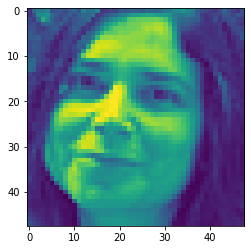

In [ ]:
plt.imshow(X_train[101].reshape(48, 48))
print(y_train[101])

In [ ]:
num_classes = np.unique(y_train).shape[0]
y_train1 = np_utils.to_categorical(y_train, num_classes)
y_test1 = np_utils.to_categorical(y_test, num_classes)

# PCA Feature Extraction For Other ML Algorithms

In [ ]:
X = data.iloc[:, :-1].values

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(.90)

In [ ]:
X1 = pca.fit_transform(X)

In [ ]:
X1.shape

(35887, 105)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28709, 105) (28709,) (7178, 105) (7178,)


# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/IR/IR_Project_Midsem/IR_Data/train',
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training")

validation_generator = train_datagen.flow_from_directory( directory = '/content/drive/MyDrive/IR/IR_Project_Midsem/IR_Data/train',
                                                          target_size = (img_size,img_size),
                                                          batch_size = 64,
                                                          color_mode = "grayscale",
                                                          class_mode = "categorical",
                                                          subset = "validation")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/IR/IR_Project_Midsem/IR_Data/test',
                                                  target_size = (img_size,img_size),
                                                  batch_size = 64,
                                                  color_mode = "grayscale",
                                                  class_mode = "categorical")

Found 7179 images belonging to 7 classes.


# SVM After Feature Extraction using PCA

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = svc.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.42867093898021735

# CNN Model 1

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 24, 128)      

## Without Data Augmentation Results

In [ ]:
model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train1, batch_size=32, epochs=50, validation_data=(X_test, y_test1))

Epoch 1/50
898/898 [==============================] - 23s 23ms/step - loss: 4.9847 - accuracy: 0.2055 - val_loss: 2.5520 - val_accuracy: 0.2771
Epoch 2/50
898/898 [==============================] - 20s 22ms/step - loss: 2.3654 - accuracy: 0.3410 - val_loss: 2.3696 - val_accuracy: 0.4089
Epoch 3/50
898/898 [==============================] - 19s 22ms/step - loss: 2.2079 - accuracy: 0.4572 - val_loss: 2.4419 - val_accuracy: 0.4004
Epoch 4/50
898/898 [==============================] - 19s 22ms/step - loss: 2.1305 - accuracy: 0.4915 - val_loss: 2.5733 - val_accuracy: 0.4156
Epoch 5/50
898/898 [==============================] - 20s 22ms/step - loss: 2.0672 - accuracy: 0.4997 - val_loss: 2.1817 - val_accuracy: 0.4556
Epoch 6/50
898/898 [==============================] - 20s 22ms/step - loss: 1.9496 - accuracy: 0.5254 - val_loss: 2.0645 - val_accuracy: 0.4904
Epoch 7/50
898/898 [==============================] - 20s 22ms/step - loss: 1.8623 - accuracy: 0.5326 - val_loss: 1.9203 - val_accuracy:

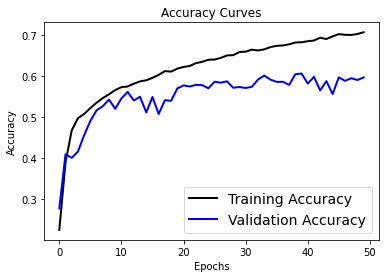

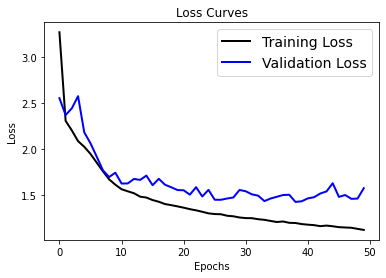

In [ ]:
plotting_epochs(history.history['accuracy'], history.history['val_accuracy'], "Accuracy")
plotting_epochs(history.history['loss'], history.history['val_loss'], "Loss")

In [ ]:
# model.save('/content/drive/MyDrive/IR/IR_Project_Midsem/Model1.h5')

## With Data Augmentation Results

In [ ]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x = train_generator, epochs = 50, validation_data = validation_generator)

Epoch 1/50
359/359 [==============================] - 10772s 30s/step - loss: 7.5516 - accuracy: 0.2141 - val_loss: 2.9977 - val_accuracy: 0.1735
Epoch 2/50
359/359 [==============================] - 34s 96ms/step - loss: 2.4923 - accuracy: 0.3498 - val_loss: 2.6605 - val_accuracy: 0.3221
Epoch 3/50
359/359 [==============================] - 34s 95ms/step - loss: 2.1961 - accuracy: 0.4570 - val_loss: 2.2185 - val_accuracy: 0.4804
Epoch 4/50
359/359 [==============================] - 34s 94ms/step - loss: 2.1990 - accuracy: 0.4973 - val_loss: 2.2126 - val_accuracy: 0.4752
Epoch 5/50
359/359 [==============================] - 34s 95ms/step - loss: 2.1564 - accuracy: 0.5116 - val_loss: 2.2182 - val_accuracy: 0.4551
Epoch 6/50
359/359 [==============================] - 34s 94ms/step - loss: 2.0620 - accuracy: 0.5293 - val_loss: 2.8133 - val_accuracy: 0.4525
Epoch 7/50
359/359 [==============================] - 34s 96ms/step - loss: 2.1003 - accuracy: 0.5355 - val_loss: 2.1465 - val_accurac

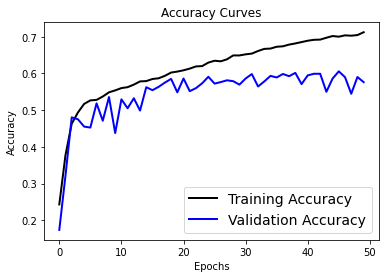

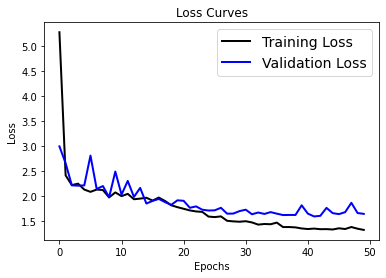

In [ ]:
plotting_epochs(history.history['accuracy'], history.history['val_accuracy'], "Accuracy")
plotting_epochs(history.history['loss'], history.history['val_loss'], "Loss")

In [ ]:
model.fit(x = train_generator, epochs = 5, validation_data = validation_generator)

Epoch 1/5
359/359 [==============================] - 35s 97ms/step - loss: 1.2946 - accuracy: 0.7160 - val_loss: 1.6794 - val_accuracy: 0.5999
Epoch 2/5
359/359 [==============================] - 35s 96ms/step - loss: 1.2792 - accuracy: 0.7201 - val_loss: 1.6123 - val_accuracy: 0.6013
Epoch 3/5
359/359 [==============================] - 34s 96ms/step - loss: 1.2341 - accuracy: 0.7264 - val_loss: 1.5988 - val_accuracy: 0.6074
Epoch 4/5
359/359 [==============================] - 34s 96ms/step - loss: 1.2314 - accuracy: 0.7271 - val_loss: 1.5589 - val_accuracy: 0.6157
Epoch 5/5
359/359 [==============================] - 34s 94ms/step - loss: 1.2095 - accuracy: 0.7252 - val_loss: 1.5844 - val_accuracy: 0.6065


In [ ]:
model.evaluate(test_generator)

113/113 [==============================] - 2410s 22s/step - loss: 1.5704 - accuracy: 0.6090


[1.5704418420791626, 0.6089984774589539]

In [ ]:
# model.save('/content/drive/MyDrive/IR/IR_Project_Midsem/Data_Augmentation_Model1.h5')

# CNN Model 2 (Best so far)

In [ ]:
model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(48,48,1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 64)       

In [ ]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train1, batch_size=32, epochs=50, validation_data=(X_test, y_test1))

Epoch 1/50
898/898 [==============================] - 11s 11ms/step - loss: 2.1452 - accuracy: 0.2494 - val_loss: 1.5363 - val_accuracy: 0.4076
Epoch 2/50
898/898 [==============================] - 9s 10ms/step - loss: 1.5282 - accuracy: 0.4097 - val_loss: 1.3634 - val_accuracy: 0.4713
Epoch 3/50
898/898 [==============================] - 9s 10ms/step - loss: 1.3781 - accuracy: 0.4737 - val_loss: 1.2827 - val_accuracy: 0.5011
Epoch 4/50
898/898 [==============================] - 9s 10ms/step - loss: 1.3074 - accuracy: 0.5016 - val_loss: 1.2563 - val_accuracy: 0.5157
Epoch 5/50
898/898 [==============================] - 9s 10ms/step - loss: 1.2555 - accuracy: 0.5250 - val_loss: 1.3634 - val_accuracy: 0.4929
Epoch 6/50
898/898 [==============================] - 9s 10ms/step - loss: 1.2024 - accuracy: 0.5434 - val_loss: 1.1449 - val_accuracy: 0.5644
Epoch 7/50
898/898 [==============================] - 9s 10ms/step - loss: 1.1784 - accuracy: 0.5567 - val_loss: 1.1674 - val_accuracy: 0.543

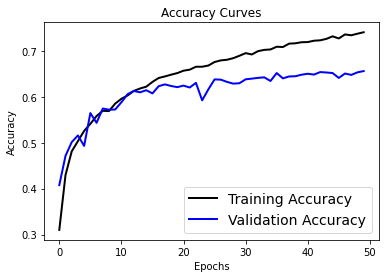

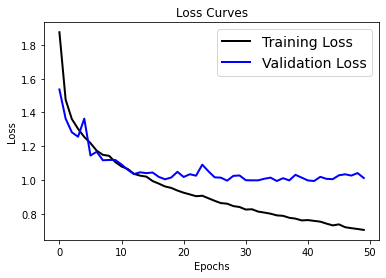

In [ ]:
plotting_epochs(history.history['accuracy'], history.history['val_accuracy'], "Accuracy")
plotting_epochs(history.history['loss'], history.history['val_loss'], "Loss")

In [ ]:
# model.save('/content/drive/MyDrive/IR/IR_Project_Midsem/Model2.h5')

In [ ]:
best_model = load_model('/content/drive/MyDrive/IR/IR_Project_Midsem/Model2.h5')

In [ ]:
history = best_model.fit(X_train, y_train1, batch_size=32, epochs=10, validation_data=(X_test, y_test1))

Epoch 1/10
898/898 [==============================] - 24s 25ms/step - loss: 0.6947 - accuracy: 0.7454 - val_loss: 1.0074 - val_accuracy: 0.6556
Epoch 2/10
898/898 [==============================] - 22s 25ms/step - loss: 0.6964 - accuracy: 0.7437 - val_loss: 1.0322 - val_accuracy: 0.6617
Epoch 3/10
898/898 [==============================] - 22s 25ms/step - loss: 0.6894 - accuracy: 0.7453 - val_loss: 1.0330 - val_accuracy: 0.6505
Epoch 4/10
898/898 [==============================] - 22s 25ms/step - loss: 0.6831 - accuracy: 0.7457 - val_loss: 1.0433 - val_accuracy: 0.6541
Epoch 5/10
898/898 [==============================] - 22s 25ms/step - loss: 0.6887 - accuracy: 0.7470 - val_loss: 1.0040 - val_accuracy: 0.6599
Epoch 6/10
898/898 [==============================] - 22s 25ms/step - loss: 0.6750 - accuracy: 0.7519 - val_loss: 1.0519 - val_accuracy: 0.6531
Epoch 7/10
898/898 [==============================] - 22s 25ms/step - loss: 0.6822 - accuracy: 0.7497 - val_loss: 1.0320 - val_accuracy:

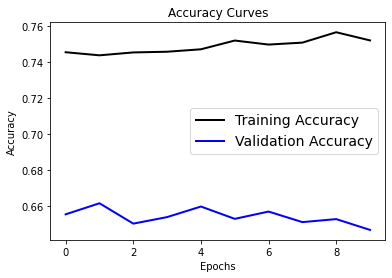

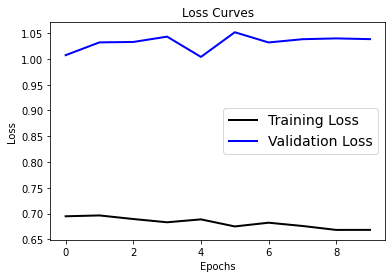

In [ ]:
plotting_epochs(history.history['accuracy'], history.history['val_accuracy'], "Accuracy")
plotting_epochs(history.history['loss'], history.history['val_loss'], "Loss")

# CNN Model 3 (Reduced Overfitting)

In [ ]:
model = Sequential()

model.add(layers.Conv2D(16,kernel_size=(3,3),padding="same",activation="relu",input_shape=(48,48,1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(16,kernel_size=(3,3),padding="same",activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32,kernel_size=(3,3),padding="same",activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32,kernel_size=(3,3),padding="same",activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64,kernel_size=(3,3),padding="same",activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64,kernel_size=(3,3),padding="same",activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4

In [ ]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train1, batch_size=32, epochs=100, validation_data=(X_test, y_test1))

Epoch 1/100
898/898 [==============================] - 41s 8ms/step - loss: 2.3096 - accuracy: 0.2269 - val_loss: 1.6139 - val_accuracy: 0.3757
Epoch 2/100
898/898 [==============================] - 6s 7ms/step - loss: 1.6539 - accuracy: 0.3547 - val_loss: 1.5061 - val_accuracy: 0.4133
Epoch 3/100
898/898 [==============================] - 6s 7ms/step - loss: 1.5107 - accuracy: 0.4137 - val_loss: 1.4026 - val_accuracy: 0.4494
Epoch 4/100
898/898 [==============================] - 7s 7ms/step - loss: 1.4154 - accuracy: 0.4541 - val_loss: 1.3533 - val_accuracy: 0.4657
Epoch 5/100
898/898 [==============================] - 6s 7ms/step - loss: 1.3509 - accuracy: 0.4843 - val_loss: 1.3087 - val_accuracy: 0.4785
Epoch 6/100
898/898 [==============================] - 7s 7ms/step - loss: 1.3259 - accuracy: 0.4958 - val_loss: 1.2472 - val_accuracy: 0.5224
Epoch 7/100
898/898 [==============================] - 7s 8ms/step - loss: 1.2803 - accuracy: 0.5129 - val_loss: 1.2527 - val_accuracy: 0.517

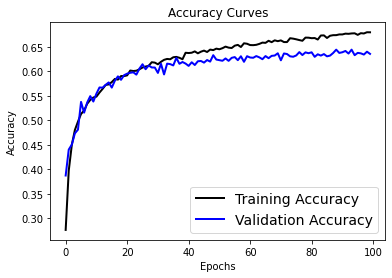

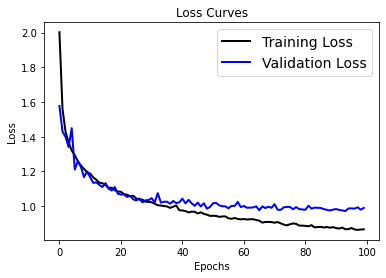

In [ ]:
plotting_epochs(history.history['accuracy'], history.history['val_accuracy'], "Accuracy")
plotting_epochs(history.history['loss'], history.history['val_loss'], "Loss")

In [ ]:
model.save('/content/gdrive/MyDrive/IR_mid_project/model_with_64accuracy.h5')

# VGG 16

In [ ]:
vgg16 = VGG16(include_top = False, weights='imagenet', pooling='avg', classes=7, input_shape=(48, 48, 3))
vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
______________________________________________________________

In [ ]:
model_vgg = Sequential()
model_vgg.add(vgg16)
model_vgg.add(keras.layers.Flatten())
model_vgg.add(Dense(512, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(7, activation = 'softmax'))

for layer in vgg16.layers[:-10]:
        layer.trainable = False

In [ ]:
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 3591      
Total params: 14,980,935
Trainable params: 13,245,447
Non-trainable params: 1,735,488
_________________________________________________________________


In [ ]:
adam = Adam(lr=0.0001)
model_vgg.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# cb_checkpointer_vgg = ModelCheckpoint(filepath = '../best_vgg.h5', monitor = 'val_loss', save_best_only = True)
fit_history = model_vgg.fit(train_generator, epochs = 10, validation_data=validation_generator)

Epoch 1/10
449/449 [==============================] - 12444s 28s/step - loss: 1.6816 - accuracy: 0.3370 - val_loss: 1.2980 - val_accuracy: 0.4967
Epoch 2/10
449/449 [==============================] - 44s 99ms/step - loss: 1.2586 - accuracy: 0.5304 - val_loss: 1.1635 - val_accuracy: 0.5704
Epoch 3/10
449/449 [==============================] - 45s 99ms/step - loss: 1.0753 - accuracy: 0.6019 - val_loss: 1.1208 - val_accuracy: 0.5798
Epoch 4/10
449/449 [==============================] - 45s 100ms/step - loss: 0.9192 - accuracy: 0.6642 - val_loss: 1.0915 - val_accuracy: 0.5931
Epoch 5/10
449/449 [==============================] - 44s 98ms/step - loss: 0.7184 - accuracy: 0.7447 - val_loss: 1.1406 - val_accuracy: 0.6219
Epoch 6/10
449/449 [==============================] - 44s 97ms/step - loss: 0.5104 - accuracy: 0.8198 - val_loss: 1.2033 - val_accuracy: 0.6358
Epoch 7/10
449/449 [==============================] - 44s 98ms/step - loss: 0.3405 - accuracy: 0.8841 - val_loss: 1.3889 - val_accura

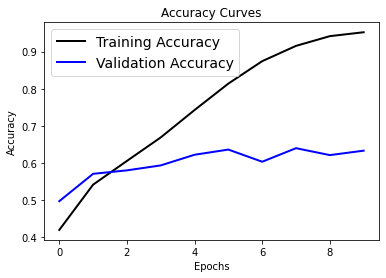

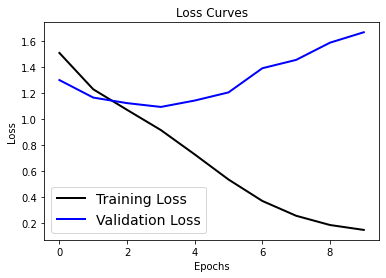

In [ ]:
plotting_epochs(fit_history.history['accuracy'], fit_history.history['val_accuracy'], "Accuracy")
plotting_epochs(fit_history.history['loss'], fit_history.history['val_loss'], "Loss")

# VGG19

In [ ]:
from keras.applications.vgg19 import VGG19
vgg19 = VGG19(weights='imagenet', include_top=False,pooling='avg', classes=7, input_shape=(48,48,3))
vgg19.summary()


80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
______________________________________________________________

In [ ]:
model_vgg19 = Sequential()
model_vgg19.add(vgg19)
model_vgg19.add(keras.layers.Flatten())
model_vgg19.add(Dense(512, activation='relu'))
model_vgg19.add(Dropout(0.6))
model_vgg19.add(Dense(7, activation = 'softmax'))

for layer in vgg19.layers[:-10]:
        layer.trainable = False

In [ ]:
adam = Adam(lr=0.0001)
model_vgg19.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# cb_checkpointer_vgg = ModelCheckpoint(filepath = '../best_vgg.h5', monitor = 'val_loss', save_best_only = True)
fit_history = model_vgg19.fit(train_generator, epochs = 20, validation_data=validation_generator)

Epoch 1/20
460/460 [==============================] - 3484s 8s/step - loss: 1.5128 - accuracy: 0.4123 - val_loss: 1.3334 - val_accuracy: 0.4940
Epoch 2/20
460/460 [==============================] - 42s 91ms/step - loss: 1.3215 - accuracy: 0.5044 - val_loss: 1.3094 - val_accuracy: 0.5125
Epoch 3/20
460/460 [==============================] - 42s 91ms/step - loss: 1.2045 - accuracy: 0.5577 - val_loss: 1.1915 - val_accuracy: 0.5555
Epoch 4/20
460/460 [==============================] - 41s 89ms/step - loss: 1.0438 - accuracy: 0.6212 - val_loss: 1.1847 - val_accuracy: 0.5586
Epoch 5/20
460/460 [==============================] - 42s 91ms/step - loss: 0.8949 - accuracy: 0.6808 - val_loss: 1.2192 - val_accuracy: 0.5678
Epoch 6/20
460/460 [==============================] - 41s 89ms/step - loss: 0.7259 - accuracy: 0.7505 - val_loss: 1.2598 - val_accuracy: 0.5671
Epoch 7/20
460/460 [==============================] - 41s 90ms/step - loss: 0.5336 - accuracy: 0.8232 - val_loss: 1.3421 - val_accuracy:

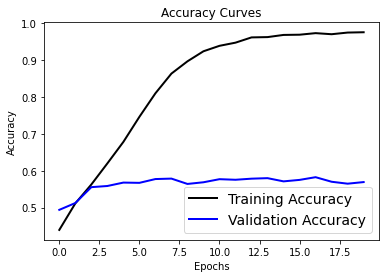

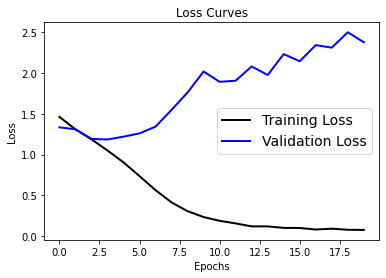

In [ ]:
plotting_epochs(fit_history.history['accuracy'], fit_history.history['val_accuracy'], "Accuracy")
plotting_epochs(fit_history.history['loss'], fit_history.history['val_loss'], "Loss")

# Resnet50

In [ ]:
from keras.applications.resnet50 import ResNet50
res = ResNet50(include_top=False,input_shape=(48, 48, 3),weights='imagenet', pooling='avg', classes=7)
res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
model_res = Sequential()
model_res.add(res)
model_res.add(keras.layers.Flatten())
model_res.add(Dense(512, activation='relu'))
model_res.add(Dropout(0.5))
model_res.add(Dense(7, activation = 'softmax'))

for layer in res.layers[:-10]:
        layer.trainable = False

In [ ]:
model_res.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 3591      
Total params: 24,640,391
Trainable params: 4,469,255
Non-trainable params: 20,171,136
_________________________________________________________________


In [ ]:
type(train_generator)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [ ]:
iter = (i for i in range(50))

In [ ]:
iterator

<generator object gen at 0x7efed2f2bed0>

In [ ]:
adam = Adam(lr=0.0001)
model_res.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# cb_checkpointer_vgg = ModelCheckpoint(filepath = '../best_vgg.h5', monitor = 'val_loss', save_best_only = True)
fit_history = model_res.fit(train_generator, epochs = 50, validation_data=validation_generator)

Epoch 1/50
460/460 [==============================] - 62s 128ms/step - loss: 1.2005 - accuracy: 0.5422 - val_loss: 1.6325 - val_accuracy: 0.4111
Epoch 2/50
460/460 [==============================] - 58s 126ms/step - loss: 1.1730 - accuracy: 0.5495 - val_loss: 1.6766 - val_accuracy: 0.4027
Epoch 3/50
460/460 [==============================] - 58s 126ms/step - loss: 1.1475 - accuracy: 0.5654 - val_loss: 1.6557 - val_accuracy: 0.4065
Epoch 4/50
460/460 [==============================] - 58s 126ms/step - loss: 1.1271 - accuracy: 0.5700 - val_loss: 1.6562 - val_accuracy: 0.4200
Epoch 5/50
460/460 [==============================] - 58s 126ms/step - loss: 1.0955 - accuracy: 0.5893 - val_loss: 1.7451 - val_accuracy: 0.4024
Epoch 6/50
460/460 [==============================] - 57s 123ms/step - loss: 1.0744 - accuracy: 0.5930 - val_loss: 1.6682 - val_accuracy: 0.4297
Epoch 7/50
460/460 [==============================] - 57s 123ms/step - loss: 1.0479 - accuracy: 0.6061 - val_loss: 1.7000 - val_ac

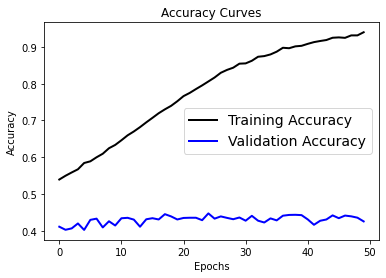

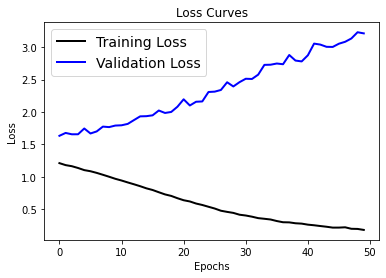

In [ ]:
plotting_epochs(fit_history.history['accuracy'], fit_history.history['val_accuracy'], "Accuracy")
plotting_epochs(fit_history.history['loss'], fit_history.history['val_loss'], "Loss")

# INCEPTION V3 Model

In [ ]:
# importing the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
incepv3 = InceptionV3(include_top = False, weights='imagenet', pooling = 'avg', classes = 7, input_shape=(75, 75, 3))
# input shape includes shape of our images
# include top = false means leave out the last fully connected layer
incepv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 37, 37, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 37, 37, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 37, 37, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
# Making all layers non-trainable; we are retraining some of lower layers to increase performance but it may lead to overfitting
for layer in incepv3.layers:
  layer.trainable = False

In [ ]:
# Optimiser = RMSprop with laerning rate of 0.0001
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(incepv3.output)
x = layers.Dense(512, activation= 'relu')(x)
x = Dropout(0.7)(x)
x = layers.Dense(7, activation= 'sigmoid')(x)

model = Model(incepv3.input, x)
model.compile(optimizer = RMSprop(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
#adam = Adam(lr=0.0001)
#model.compile(optimizer= adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Data Augmentation 

In [ ]:
# Data Augmentation :
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
                                   #validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/IR_project/IR_Project_Midsem/IR_Data/train',
                                                    target_size = (75, 75),
                                                    batch_size = 64,
                                                    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory( directory = '/content/drive/MyDrive/IR_project/IR_Project_Midsem/IR_Data/test',
                                                          target_size = (75,75),
                                                          batch_size = 64,
                                                          class_mode = "categorical")

Found 28709 images belonging to 7 classes.
Found 7179 images belonging to 7 classes.


In [ ]:
#test_generator = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/IR_project/IR_Project_Midsem/IR_Data/test',
#                                                  target_size = (img_size,img_size),
#                                                  batch_size = 64,
#                                                  class_mode = "categorical")

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 37, 37, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 37, 37, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 37, 37, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [ ]:
history = model.fit_generator(train_generator, 
                              validation_data = validation_generator,
                              epochs = 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
449/449 [==============================] - 7585s 17s/step - loss: 2.2000 - acc: 0.2218 - val_loss: 1.7029 - val_acc: 0.3158
Epoch 2/10
449/449 [==============================] - 376s 837ms/step - loss: 1.7794 - acc: 0.2855 - val_loss: 1.6769 - val_acc: 0.3254
Epoch 3/10
449/449 [==============================] - 375s 835ms/step - loss: 1.7470 - acc: 0.3055 - val_loss: 1.6575 - val_acc: 0.3432
Epoch 4/10
449/449 [==============================] - 375s 835ms/step - loss: 1.7299 - acc: 0.3068 - val_loss: 1.6573 - val_acc: 0.3443
Epoch 5/10
449/449 [==============================] - 376s 836ms/step - loss: 1.7241 - acc: 0.3129 - val_loss: 1.6433 - val_acc: 0.3535
Epoch 6/10
449/449 [==============================] - 375s 835ms/step - loss: 1.7048 - acc: 0.3262 - val_loss: 1.6457 - val_acc: 0.3545
Epoch 7/10
449/449 [==============================] - 375s 834ms/step - loss: 1.6917 - acc: 0.3368 - val_loss: 1.6380 - val_acc: 0.3523
Epoch 8/10
449/449 [=============================

# Predicting Emotions Using Best Model so far

In [ ]:
def predict_emotion(model, image, original_label):
  emotions = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'neutral', 5:'sad', 6:'surprise'}
  plt.imshow(image.reshape(48, 48))
  print('Original Emotion: ',emotions[original_label])
  predictions = model.predict(image.reshape(1, 48, 48, 1))
  y_pred = np.argmax(predictions)
  emo = emotions[y_pred]
  intensity = np.max(predictions)
  print('Predicted Emotion: ', emo)
  print('Intensity Of Emotion: {0:.3f}%'.format(intensity*100))
  return emo, intensity

Example of Correct Classification

Original Emotion:  neutral
Predicted Emotion:  neutral
Intensity Of Emotion: 98.709%


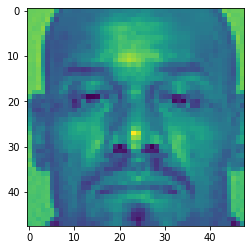

In [ ]:
emot, intensity = predict_emotion(best_model, X_test[7], y_test[7])

Example of Wrong Classification

Original Emotion:  angry
Predicted Emotion:  sad
Intensity Of Emotion: 63.484%


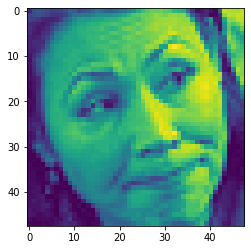

In [ ]:
emot, intensity = predict_emotion(best_model, X_test[1000], y_test[1000])

# Songs Playlist Suggestion

In [ ]:
google_sheet_id = '1AmlOC6RN-pYKdU6nU2e2dmxXPYhJGc3zWknkKQFt9O4'
worksheetname = 'IR_Playlist_Data'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(google_sheet_id, worksheetname)

In [ ]:
data = pd.read_csv(URL)

In [ ]:
playlist = data.iloc[:, :].values

Emotion to Genre Mappings

In [ ]:
mappings = {
    0: ['Instrumental', 'Classical', 'Ballad'],
    1: ['Ballad', 'Instrumental', 'Rock'],
    2: ['EDM', 'Jazz', 'Rock', 'Pop'],
    3: ['Pop', 'Rock', 'EDM', 'Blues', 'Hip Hop'],
    4: ['Classical', 'Instrumental'],
    5: ['Folk', 'Rock', 'Pop'],
    6: ['EDM', 'Rock', 'Jazz']
}

Suggestions based on emotion detected

In [ ]:
def suggest(emotion, mappings, playlist):
  emotions = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'neutral':4, 'sad':5, 'surprise':6}
  emotion_label = emotions[emotion]
  list_data = []
  genres = playlist[:, 2]
  for i in mappings[emotion_label]:
    for j in range(len(genres)):
      if genres[j] == i:
        list_data.append(playlist[j])
  random.shuffle(list_data)
  print('We suggest you this playlist:', list_data[0][1])
  print('Genre:', list_data[0][2])
  print('Artist:', list_data[0][3])
  print('Language:', list_data[0][4])

Original Emotion:  surprise
Predicted Emotion:  surprise
Intensity Of Emotion: 99.998%
We suggest you this playlist: https://www.youtube.com/watch?v=ZYJ_4cPqfu8
Genre: Rock
Artist: Yo Yo Honey Singh
Language: Punjabi


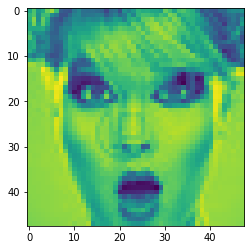

In [ ]:
n = random.randint(0, 7177)
emot, intensity = predict_emotion(best_model, X_test[n], y_test[n])
suggest(emot, mappings, playlist)

Original Emotion:  surprise
Predicted Emotion:  fear
Intensity Of Emotion: 35.112%
We suggest you this playlist: https://gaana.com/playlist/gaana-dj-bollywood-style-jazz
Genre: Jazz
Artist: Multiple
Language: Hindi


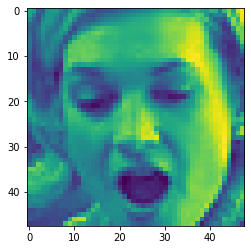

In [ ]:
n = random.randint(0, 7177)
emot, intensity = predict_emotion(best_model, X_test[n], y_test[n])
suggest(emot, mappings, playlist)

Original Emotion:  happy
Predicted Emotion:  happy
Intensity Of Emotion: 97.053%
We suggest you this playlist: https://youtu.be/jT87udqp2j0
Genre: Pop
Artist: Ed Sheeran
Language: English


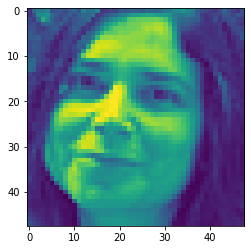

In [ ]:
emot, intensity = predict_emotion(best_model, X_train[101], y_train[101])
suggest(emot, mappings, playlist)